# Adventureworks försäljningsanalys

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Lejonkatt123!")
server = 'localhost:1434'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\shara\AppData\Local\Temp\ipykernel_24144\2655009714.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [3]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)
    

## Analys 1 - Antal produkter per kategori
**Affärsfråga: Hur många produkter finns i varje kategori?**

Tabeller som används: Production.ProductCategory, Production.ProductSubcategory, Production.Product

**Plan**
1. JOINA tabellerna för att hämta Kategorinamn och räkna antal unika ProductID inom varje kategori
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med vertikalt stapeldiagram med etiketter ovanför varje stapel
4. Analysera resultatet - Krav på insikt: **Förklara vilken kategori som har flest/minst produkter.**

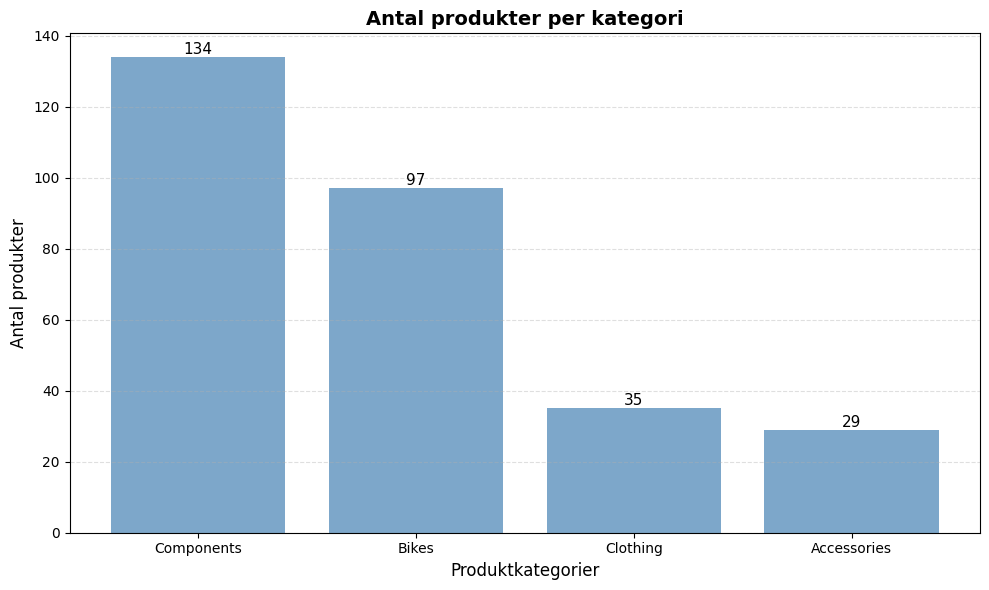

In [4]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha = 'center',
        va = 'bottom',
        fontsize=11
    ) 

ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Produktkategorier',fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12 )
ax.grid(axis='y',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Insikter - Antal produkter per kategori
Resultatet visar att **Components** har flest produkter (134). Detta tyder på att Adventure Works har ett brett sortiment av komponenter, vilket är rimligt för ett cykelföretag där delar som ramar, pedaler och andra komponenter är viktiga för både anpassning och underhåll av cyklar. Det kan även indikera ett tydligt fokus på reparationer och uppgraderingar, vilket i sin tur kan bidra till återkommande försäljning.

Kategorin **Accessories** har istället det minsta antalet produkter (29) vilket antyder att tillbehör som exempelvis hjälmar inte är ett lika prioriterat område. Genom att bredda sortimentet inom både kläder och accessoarer skulle företaget kunna skapa bättre möjligheter till merförsäljning och kompletterande köp.

## Analys 2 - Försäljning per produktkategori
**Affärsfråga: Vilka produktkategorier genererar mest intäkter?**

Tabeller som används: Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail

**Plan**
1. JOINA tabellerna för att hämta Kategorinamn och räkna ut totalsumman av ordrar inom varje kategori
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med horisontellt stapeldiagram, sortera från högst till lägst (högsta överst)
4. Skriva ut största och minsta kategori med exakta siffror då detta är en del av kravet
5. Analysera resultatet - Krav på insikt: **Förklara vilken kategori som är störst och minst, med exakta siffror.**

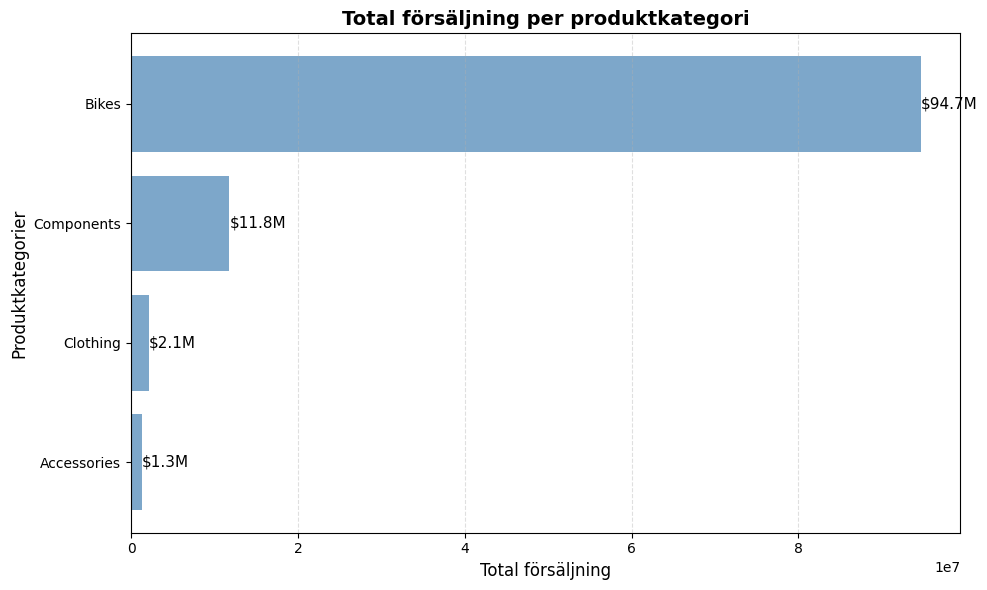

Största kategori: Bikes med totala försäljningen: $ 94,651,172.704731
Minsta kategori: Accessories med totala försäljningen: $ 1,272,072.883926


In [ ]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID 
GROUP BY pc.Name
ORDER BY TotalSales DESC 
"""

df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis2['CategoryName'][::-1], df_vis2['TotalSales'][::-1], color='steelblue', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width +1,
        bar.get_y() + bar.get_height()/2,
        f'${width/1_000_000:.1f}M',
        va = 'center',
        ha = 'left',
        fontsize=11
    ) 

ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning',fontsize=12)
ax.set_ylabel('Produktkategorier', fontsize=12 )
ax.grid(axis='x',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Största kategori: {df_vis2.iloc[0]['CategoryName']} med totala försäljningen: $ {df_vis2.iloc[0]['TotalSales']:,}")
print(f"Minsta kategori: {df_vis2.iloc[-1]['CategoryName']} med totala försäljningen: $ {df_vis2.iloc[-1]['TotalSales']:,}")


### Insikter - Försäljning per produktkategori
Den klart strörsta produktkategorin är **Bikes** med en total försäljning på ca **$94,7 M**.   
Detta visar att cykelförsäljningen är kärnan i AdventureWorks verksamhet och den främsta intäktskällan.  
Samtidigt innebär det att företaget är relativt beroende av denna kategori, vilket gör att förändringar i efterfrågan på cyklar – exempelvis på grund av säsong eller konkurrens – kan få stor påverkan på det totala resultatet.

Den kategorin som genererar minst i försäljning är **Accessories** med en total omstättning på ca **$1,3 M**. Detta indikerar att tillbehör i nuläget utgör en mycket liten andel av företagets totala intäkter. Det kan även ses som en potentiell utvecklingsmöjlighet, där ett bredare sortiment eller ökad marknadsföring skulle kunna bidra till högre försäljning inom denna kategori.  




## Analys 3 - Försäljningstrend över tid
**Affärsfråga: Hur har försäljningen utvecklats över tid?**

Tabeller som används: Sales.SalesOrderHeader

**Plan**
1. Formatera om 'Orderdate' så det går att gruppera på månad samt summera totalförsäljning
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med linjediagram
4. Skriv ut månaderna med största/minsta totala försäljning
5. Visualisera med ytterligre ett linjediagram för att göra säsongsaspekterna tydligare
5. Analysera resultatet - Krav på insikt: **Beskriv trenden - ökar den, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.**

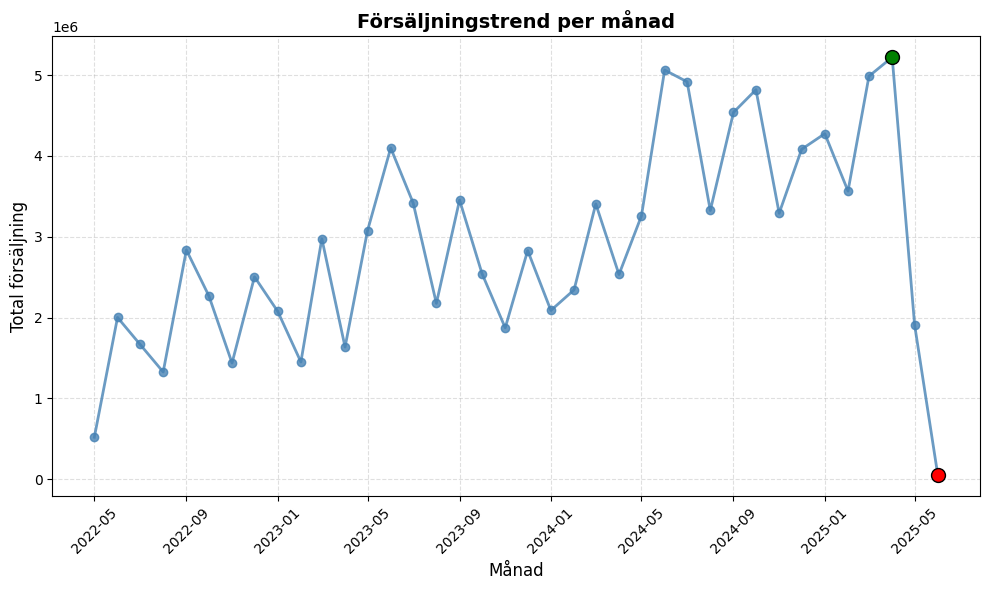

Högsta försäljningen inträffade: April-2025 med totala försäljningen: $ 5,222,759
Minsta försäljningen inträffade: June-2025 med totala försäljningen: $ 47,492


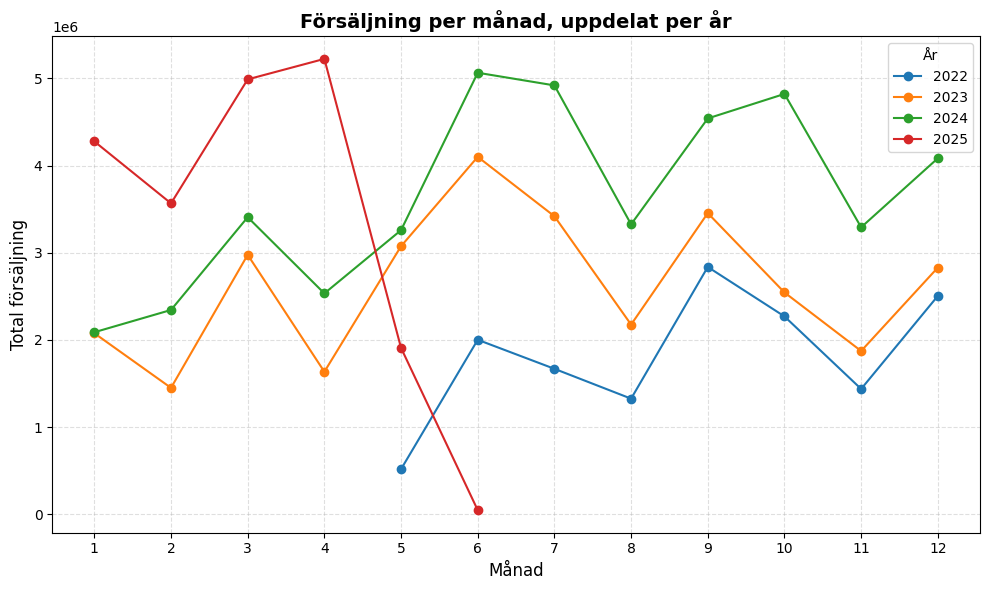

In [29]:
query_vis3 = """
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS YearMonth,
    SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY YearMonth
"""

df_vis3 = query_df(query_vis3)
max_row = df_vis3.loc[df_vis3['TotalSales'].idxmax()]
min_row = df_vis3.loc[df_vis3['TotalSales'].idxmin()]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_vis3['YearMonth'], df_vis3['TotalSales'], color='steelblue', linewidth=2, marker='o',alpha=0.8)
ax.scatter(max_row['YearMonth'], max_row['TotalSales'], color='green', edgecolors='black', s=100, zorder=5)
ax.scatter(min_row['YearMonth'], min_row['TotalSales'], color='red', edgecolors='black', s=100, zorder=5)
ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')
ax.set_xlabel('Månad',fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12 )
ax.grid(True,linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Högsta försäljningen inträffade: {max_row['YearMonth'].strftime('%B-%Y')} med totala försäljningen: $ {max_row['TotalSales']:,.0f}")
print(f"Minsta försäljningen inträffade: {min_row['YearMonth'].strftime('%B-%Y')} med totala försäljningen: $ {min_row['TotalSales']:,.0f}")

# Graf som visar år/säsongstrender tydligare
df_vis3['YearMonth'] = pd.to_datetime(df_vis3['YearMonth'])
df_vis3['Year'] = df_vis3['YearMonth'].dt.year
df_vis3['Month'] = df_vis3['YearMonth'].dt.month

fig, ax = plt.subplots(figsize=(10,6))
for year in sorted(df_vis3['Year'].unique()):
    df_year = df_vis3[df_vis3['Year'] == year]
    ax.plot(
        df_year['Month'],
        df_year['TotalSales'],
        marker='o',
        label=str(year)
    )

ax.set_title("Försäljning per månad, uppdelat per år", fontsize=14, fontweight='bold')
ax.set_xlabel("Månad", fontsize=12)
ax.set_ylabel("Total försäljning", fontsize=12)
ax.set_xticks(range(1,13))  # 1-12 månader
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='År')
plt.tight_layout()
plt.show()


### Insikter - Försäljningstrend över tid
**Övergripande trend**  
Försäljningen visar en tydlig **stigande** trend över perioden från mitten av 2022 till början av 2025. Det innebär att AdventureWorks har ökat sin försäljning över tid, vilket är positivt för företagets utveckling.

**Säsongsvariationer**  
I båda graferna syns tydliga **säsongsmönster** med regelbundna toppar och dalar under varje år.
Vanligtvis är det högre försäljning under vår/sommar och i slutet av året – troligen kopplat till vädersäsong + julhandel.

**Högsta och lägsta månad**  
Högsta försäljningen inträffade i början av 2025 (markerad med grön punkt i första grafen), med över 5 miljoner dollar i försäljning
Lägsta försäljningen skedde i mitten av 2025 (markerad med röd punkt), med en försäljning på endast ca 47 000 dollar. (Vilket kan beror på att datan där är ofullständig.)

**Observationer/avvikelser**  
Den plötsliga "kollapsen" 2025 är alarmerande och avviker helt från tidigare mönster. Detta kan indikera externa faktorer (t.ex. lågkonjektur, leveransproblem) eller interna problem (t.ex datakvalitetsfel) För att kunna analysera datan vidare behövs ytterligare en utredning.

## Analys 4 - Försäljning och antal ordrar per år
**Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?**

In [7]:
# Kod

### Insikter - Försäljning och antal ordrar per år

## Analys 5 -  Top 10 produkter
**Affärsfråga:  Vilka 10 produkter genererar mest försäljning?**

In [8]:
# Kod

### Insikter - Top 10 produkter

## Analys 6 - Försäljning och antal kunder per region
**Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?**

In [9]:
# Kod

### Insikter - Försäljning och antal kunder per region

## Analys 7 - Genomsnittligt ordervärde per region och kundtyp
**Affärsfråga: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?**

In [10]:
# Kod

### Insikter - Genomsnittligt ordervärde per region och kundtyp